In [1]:
## Python package imports
import numpy as np
import matplotlib
import scipy.integrate as sint
import matplotlib.pyplot as plt

## respic imports 
import solvers
import particles
import fields
import utilities
import diagnostics
import constants

## rsbeams import
from rsbeams.rsptcls import bunch

pi = np.pi

q = constants.cgs_constants['q']
c = constants.cgs_constants['c']
m_e = constants.cgs_constants['m_e']
m_p = constants.cgs_constants['m_p']


In [2]:
## Particle definitions 
sigma_x = 0.1
Q_mks = 1.0e-10
ds = 0.1
s = 0

Q = constants.charge_mks_to_cgs(Q_mks)

## This is where we initialize a KV distribuiton
npart = 1000
newKVBunch = bunch.StandardBunch(npart, dist='KV')
newKVBunch.set_longitudinal_coordinates(dpop=0.01) #here we reset the dpop value
newKVBunch.set_transverse_coordinates(betax = 1000, betay = 1000)

new_distribution = newKVBunch
new_distribution.type = 'KV'
new_distribution.e_x = 1.0e-10
new_distribution.e_y = 1.0e-10
new_distribution.N = newKVBunch.npart
new_distribution.x = newKVBunch.particles[:,0]
new_distribution.xp = newKVBunch.particles[:,1]
new_distribution.y = newKVBunch.particles[:,2]
new_distribution.yp = newKVBunch.particles[:,3]
new_distribution.z = newKVBunch.particles[:,4]
new_distribution.pz = newKVBunch.particles[:,5]

sigma_x = np.max(np.sqrt(new_distribution.x**2 + new_distribution.y**2))

## This is where we set the domain size 
L_0 = 10. * sigma_x ## Half the domain size
L_min = L_0 / 40 ## minimum wavelength to resolve

## This is where we set the energy
E = 0.02e6

## Particle distributions
my_kv_beam = particles.particles_2D_delta(new_distribution, # dx_tent = 1 * L_min, dy_tent = 1 * L_min, 
    bunch_charge = Q, species_charge = q, species_mass = m_e, K_e = E)

## Define the fields 
my_kv_fields = fields.cartesian_2D(L_x = L_0, L_y = L_0,
    L_x_min = L_min, L_y_min = L_min)

## This is where we instantiate the solver
field_solver = solvers.field_solver_2D()
my_kv_fields.register_solver(field_solver)

## instantiate the diagnostics 
ptcl_diag = diagnostics.bunch_statistics()


# Plot the phase-space for verification 
#utilities.plot_beam(my_kv_beam)

In [3]:

# Load the maps and define the stepper
maps = solvers.symplectic_maps()

def step(fields, particles, ds = ds):

    maps.drift(particles, ds = ds / 2.)
    maps.space_charge_kick_2D(fields, particles, ds = ds)
    maps.drift(particles, ds = ds / 2.)

In [4]:
## Initialize the diagnostics and run the simulation for 100 steps
ptcl_diag.update(s, my_kv_beam)

k = 0

while k < 10:

    step(my_kv_fields, my_kv_beam)
    
    s = s + ds
    
    ptcl_diag.update(s, my_kv_beam)
        
    k = k + 1

In [5]:
## Compute analytic expansion for benchmarkiung. 

s_array = ptcl_diag.get_parameter('s') / 100.

r_analyitic = utilities.round_beam_expansion(s_array, 
            my_kv_beam.e_x / np.pi, my_kv_beam.e_y / np.pi, sigma_x / 100., sigma_x / 100., 
            Q_mks , my_kv_beam.gamma, my_kv_beam.m_0)



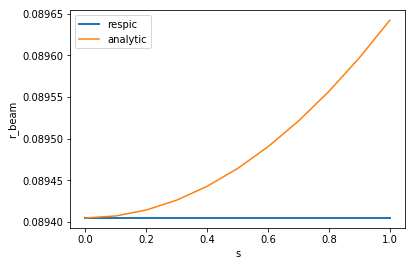

In [6]:
## Plotting 

x_key = 's'
y_key = 'r_beam'

plt.figure()
ptcl_diag.plot(x_key, y_key)
plt.plot(s_array*100, r_analyitic[:,0] * 100)
plt.xlabel(x_key)
plt.ylabel(y_key)
plt.legend(['respic', 'analytic'])
plt.show()


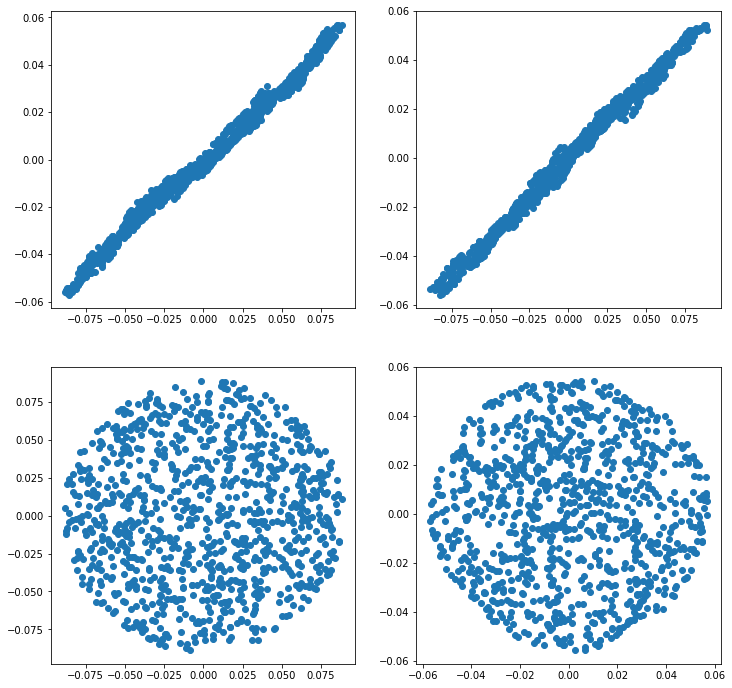

In [7]:
utilities.plot_beam(my_kv_beam)